<a href="https://colab.research.google.com/github/Jorbnc/MAIA-DL/blob/master/Mini_Proyecto_2_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

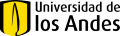

<style>
@import url('https://fonts.googleapis.com/css2?family=Latin+Modern+Roman:wght@400;700&display=swap');

body, p, h1, h2, h3, h4, h5, h6, li {
  font-family: 'Latin Modern Roman', serif;
}
code, pre {
  font-family: 'Fira Mono', monospace;
}
</style>

***

# **Miniproyecto 2, Técnicas de *Deep Learning*: Clasificación de Sentimientos de Reseñas de Películas en *IMDB* con Redes Neuronales Recurrentes**

## **Descripción del problema:**

En este proyecto abordamos el problema de clasificación de sentimiento en reseñas de películas. Partimos de un conjunto de datos extraído de *Kaggle* que contiene reseñas textuales (**`text`**) y una etiqueta binaria (**`label`**) que indica si la opinión es positiva (**1**) o negativa (**0**). El reto consiste en diseñar un modelo de *Deep Learning*, concretamente una Red Neuronal Recurrente con capas **LSTM**, capaz de procesar secuencias de texto y predecir con alta precisión la polaridad de cada reseña.

## **Objetivo:**

* Implementar un *pipeline* completo que incluya la descarga del *dataset*, el preprocesamiento de texto (tokenización, limpieza, construcción de vocabulario y *padding* de secuencias), y la definición de un *Dataset* y *DataLoader* en **PyTorch**, tomando como referencias trabajos externos [¹].

* Diseñar una arquitectura basada en *embeddings* y una o varias capas LSTM (bidireccionales), con regularización por *dropout* y optimización con **`Adam`**.

* Entrenar el modelo utilizando GPU cuando esté disponible, incorporando técnicas de **`Early Stopping`** y *gradient clipping* para evitar sobreajuste y explosión de gradientes.

* Evaluar su desempeño final sobre el conjunto de prueba, calculando *accuracy*, *F1‑score*, *recall* y presentando la matriz de confusión.

* Visualizar la evolución de la pérdida y la exactitud en entrenamiento y validación a lo largo de las épocas.

***

**Este proyecto es realizado por Andrés Felipe Ñungo y Jordan Bryan Núñez Campos para entrega el 13 de mayo de 2025.**



***
# **Índice**

El *notebook* aborda el proyecto con la siguiente estructura:

| 🔹 | Sección        |
|----|----------------|
| 1️⃣. | **Instalación y carga de librerías** |
| 1️⃣.1️⃣. | **Word2Vec** |
| 1️⃣.2️⃣. | **GloVe** |
| 1️⃣.3️⃣. | **Configuraciones adicionales** |
| 2️⃣. | **Análisis exploratorio y preparación de los datos**       |
| 2️⃣.1️⃣. | **Carga y estadísticas generales**       |
| 2️⃣.2️⃣. | **Limpieza de los datos**       |
| 3️⃣. | **Definición de *pipelines* de procesamiento**          |
| 3️⃣.1️⃣. | **Pipeline de preprocesamiento**   |
| 4️⃣. | **Desarrollo del modelo RNN**   |
| 4️⃣.1️⃣. | **Hiperparámetros, Partición y DataLoaders**   |
| 4️⃣.2️⃣. | **Definición del modelo**   |
| 4️⃣.3️⃣. | **Entrenamiento, validación y prueba**   |
| 5️⃣. | **Análisis de resultados y discusión**   |
| 5️⃣.1️⃣. | **Pruebas individuales del modelo**   |
| 6️⃣. | **Conclusión**   |
| 7️⃣. | **Referencias**   |


***

# 1. Instalación y carga de librerías

Después de la instalación de algunas librerías (algunas instalaciones se usan para que el proyecto funcione correctamente en *Coursera*), se importan utilidades generales (**`os`**, **`random`**,**`time`**, **`NumPy`**, **`pandas`**), librerías para descarga de *datasets* y de *embeddings*. Adicionalmente, se importan librerías para el procesamiento de documentos y herramientas de PLN con **`NLTK`** (incluida la descarga de *stop-words*), módulos de **`PyTorch`** para construir y entrenar la red, métricas de **`scikit-learn`** y utilidades de visualización con **`Matplotlib`**.

In [ ]:
# Instalación de librerías necesarias para correr en Colab/Coursera
%pip install -q --no-cache-dir kagglehub langdetect
%pip install -q --no-cache-dir huggingface_hub
%pip install -q --no-cache-dir nltk
%pip install -q --no-cache-dir wordcloud
%pip install -q --no-cache-dir plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# Librerías comunes
import os
import random
import time
import numpy as np
import pandas as pd
import sys
import types

# Descarga de datasets y de embeddings
import kagglehub
from huggingface_hub import hf_hub_download
#Extracción de diccionarios
import pickle

# Preprocesamiento y herramientas de PLN
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from langdetect import detect

# Palabras vacías
nltk.download('stopwords')

# Modelado
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

# Evaluación
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix

# Librerías para visualizaciones
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import plotly.express as px

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Se descarga el conjunto de datos de reseñas de películas IMDB utilizando **`kagglehub`**. La función **`dataset_download`** guarda los archivos de manera local y devuelve la ruta absoluta, que se almacena en **`path`** y se muestra en pantalla mediante **`print`** para confirmar dónde quedaron los datos.

In [ ]:
# Descarga del conjunto de datos
path = kagglehub.dataset_download("yasserh/imdb-movie-ratings-sentiment-analysis")
print("Datos descargados en:", path)

Datos descargados en: /kaggle/input/imdb-movie-ratings-sentiment-analysis


A continuación, se descargan los *embeddings* pre-entrenados, que nos permitirán tener un nuevo espacio de representación mucho más enriquecido.

## 1.1. Word2Vec

*Word2Vec GoogleNews* es un modelo que contiene 3 millones de vectores de 300 dimensiones entrenados con cerca de 100 mil millones de palabras del corpus *Google News*. Los autores sustituyeron las redes n-gram tradicionales por dos arquitecturas sencillas (CBOW y Skip-gram) con optimizaciones como *negative sampling* y *sub-sampling* de palabras frecuentes. Esto permitió entrenar *embeddings* de alta calidad en cuestión de horas [²].

In [ ]:
# Carga de del .model y el .npy Word2Vec google news más adelante, desde HugginFace
model_file = hf_hub_download(repo_id="fse/word2vec-google-news-300", filename="word2vec-google-news-300.model")
vectors_npy = hf_hub_download(repo_id="fse/word2vec-google-news-300",filename="word2vec-google-news-300.model.vectors.npy")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


word2vec-google-news-300.model:   0%|          | 0.00/182M [00:00<?, ?B/s]

(…)rd2vec-google-news-300.model.vectors.npy:   0%|          | 0.00/3.60G [00:00<?, ?B/s]

## 1.2. GloVe
GloVe es un algoritmo no supervisado para la obtención de representaciones vectoriales de palabras. Utilizaremos los vectores pre-entrenados publicados en la web de la Universidad de Stanford.

In [ ]:
# Descarga de GloVe
!wget -P . http://nlp.stanford.edu/data/glove.6B.zip
!unzip -o glove.6B.zip -d .

--2025-05-12 01:31:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-12 01:31:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-12 01:31:06--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘./glove.6B.zip’

gl

## 1.3. Configuraciones adicionales

Con el siguiente bloque se detecta si el entorno dispone de GPU y selecciona el **`device`** apropiado para PyTorch.  

Primero se llama a **`is_available()`**, que devuelve *True* si se ha asignado una GPU CUDA al *runtime* de Colab. Según el resultado se imprime un mensaje informativo. Posteriormente, se construye el objeto **`device`**, que será pasado a la red y a los tensores de entrada para que se ubiquen en la GPU cuando sea posible. Por último se muestra en pantalla el dispositivo elegido.

In [ ]:
# Devuelve asignación de GPU
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print("Entrenando en GPU.")
else:
    print("GPU no disponible, entrenando en CPU.")

# Elegir device según disponibilidad
device = torch.device("cuda" if train_on_gpu else "cpu")
print(f"   Usando device: {device}\n")

Entrenando en GPU.
   Usando device: cuda



Adicionalmente se ocultan avisos para mantener limpias algunas salidas del notebook; y se imprimen las versiones de un conjunto de librerías clave ( **`numpy`**, **`pandas`**, **`torch`**, **`scikit-learn`**, **`kagglehub`**, **`matplotlib`** ). Mostrar estas versiones al inicio del notebook facilita la reproducibilidad y ayuda a depurar posibles conflictos de dependencias.

In [ ]:
# Ignorar las warnings
import warnings
warnings.filterwarnings("ignore")

# Versiones utilizadas
from importlib.metadata import version
librerias = ["numpy", "pandas", "torch", "scikit-learn", "kagglehub","matplotlib","nltk"]
for library in librerias:
  print(library, ": ", version(library))

numpy :  2.0.2
pandas :  2.2.2
torch :  2.6.0+cu124
scikit-learn :  1.6.1
kagglehub :  0.3.12
matplotlib :  3.10.0
seaborn :  0.13.2
nltk :  3.9.1


Finalmente, para cerrar esta sección se configuran algunas semillas para tener cierto grado de control en la aleatoriedad.

In [ ]:
# Definición del random state y seeds
RANDOM_STATE = 13
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

***

# 2. Análisis exploratorio y preparación de los datos


***

## 2.1. Carga y estadísticas generales

In [ ]:
# Leer el conjunto de datos y cargarlo a un dataframe
data_raw = pd.read_csv(os.path.join(path, 'movie.csv'))
data_raw.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [ ]:
# Mapeos auxiliares para las clases
label2index = {'Negativa':0, 'Positiva':1}
index2label = {0:'Negativa', 1:'Positiva'}

In [ ]:
# Frecuencias absoluta y relativa de cada clase
pd.DataFrame({
    "Review": index2label,
    "F. Absoluta": data_raw['label'].value_counts().sort_index(),
    "F. Relativa": data_raw['label'].value_counts(normalize=True).sort_index(),
})

,Review,F. Absoluta,F. Relativa
0,Negativa,20019,0.500475
1,Positiva,19981,0.499525


***

## 2.2. Limpieza de los datos

En estas sección identificamos y corregimos:

* Valores faltantes
* Textos duplicados
* Textos en otros idiomas distintos al inglés

In [ ]:
data_raw.isna().sum()

,0
text,0
label,0


In [ ]:
data_raw.duplicated().sum()

np.int64(277)

In [ ]:
# Limpieza de duplicados
data = data_raw.drop_duplicates(keep='first')

# Nuevas frecuencias absoluta y relativa de cada clase
pd.DataFrame({
    "Review": index2label,
    "F. Absoluta": data['label'].value_counts().sort_index(),
    "F. Relativa": data['label'].value_counts(normalize=True).sort_index(),
})

,Review,F. Absoluta,F. Relativa
0,Negativa,19815,0.498829
1,Positiva,19908,0.501171


Detectando otros idiomas:

In [ ]:
def detectar_idiomas(X: pd.DataFrame):
    #Identificar los idiomas del dataframe y los índices de las filas que no están en inglés
    X['idioma'] = X['text'].apply(lambda x: detect(x) if isinstance(x, str) and x.strip() else "desconocido")
    indices_a_traducir = X[X['idioma'] != 'en'].index

    # Imprimir textos en otros idiomas
    print("Textos en otros idiomas:")
    for i in indices_a_traducir:
        print(X.loc[i].text)

    # Retornar el df ahora con la columna 'idioma'
    print("Dataset con columna 'idioma':")
    return X

Nota: En algunas ocasiones, la función `detect` confunde la presencia de nombres propios o pequeñas secciones en otros idiomas como un indicativo de que el texto no está en inglés. Sin embargo, estas ocurrencias suelen ser mínimas o nulas.

In [ ]:
detectar_idiomas(data)

Textos en otros idiomas:
More suspenseful, more subtle, much, much more disturbing....
Dataset con columna 'idioma':


,text,label,idioma
0,I grew up (b. 1965) watching and loving the Th...,0,en
1,"When I put this movie in my DVD player, and sa...",0,en
2,Why do people who do not know what a particula...,0,en
3,Even though I have great interest in Biblical ...,0,en
4,Im a die hard Dads Army fan and nothing will e...,1,en
...,...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1,en
39996,This movie is an incredible piece of work. It ...,1,en
39997,My wife and I watched this movie because we pl...,0,en
39998,"When I first watched Flatliners, I was amazed....",1,en


***

# 3. Definición de *pipelines* de procesamiento

***

## 3.1. *Pipeline* de preprocesamiento

Se construye el conjunto **`english_stop`** a partir de las *stop-words* inglesas de **`NLTK`** y se define la función **`clean_and_tokenize`**[¹]:

In [ ]:
english_stop = set(stopwords.words('english'))

# Función para limpiar y convertir las reseñas a listas de tokens de palabras
def clean_and_tokenize(text):
    # Regex:
    # Ignorar strings entre los caracteres < > (tags HTML encontrados en el dataset)
    # [a-z0-9]+ (letras y dígitos)
    # [!?] (exclamación y preguntas)
    text = re.sub(r'<[^>]+>', ' ', text).lower()
    pattern = r"[a-z0-9]+|[!?]"
    raw_tokens = re.findall(pattern, text)

    # Filtrar stopwords solo en tokens alfanuméricos
    cleaned = []
    for tok in raw_tokens:
        if re.fullmatch(r"[a-z0-9]+", tok):
            if tok in english_stop:
                continue
        cleaned.append(tok)

    return cleaned

# Prueba
print(clean_and_tokenize(data.loc[0, 'text']))

['grew', 'b', '1965', 'watching', 'loving', 'thunderbirds', 'mates', 'school', 'watched', 'played', 'thunderbirds', 'school', 'lunch', 'school', 'wanted', 'virgil', 'scott', 'one', 'wanted', 'alan', 'counting', '5', 'became', 'art', 'form', 'took', 'children', 'see', 'movie', 'hoping', 'would', 'get', 'glimpse', 'loved', 'child', 'bitterly', 'disappointing', 'high', 'point', 'snappy', 'theme', 'tune', 'could', 'compare', 'original', 'score', 'thunderbirds', 'thankfully', 'early', 'saturday', 'mornings', 'one', 'television', 'channel', 'still', 'plays', 'reruns', 'series', 'gerry', 'anderson', 'wife', 'created', 'jonatha', 'frakes', 'hand', 'directors', 'chair', 'version', 'completely', 'hopeless', 'waste', 'film', 'utter', 'rubbish', 'cgi', 'remake', 'may', 'acceptable', 'replacing', 'marionettes', 'homo', 'sapiens', 'subsp', 'sapiens', 'huge', 'error', 'judgment']


Se construye el vocabulario y define la función de codificación:

1. **`all_tokens`** genera una lista con todos los tokens de cada reseña tras aplicar limpieza y tokenización.  
2. Con **`Counter`** se calcula **`freq`**, el conteo de frecuencia de cada token.  
3. Se crea **`vocab`** con las **TOP = 20 000** palabras más frecuentes, asignando índices a partir de **4**; los índices **0**, **1**, **2** y **3** quedan reservados para los símbolos especiales **`<PAD>`**, **`<UNK>`**, **`<SOS>`** y **`<EOS>`**, respectivamente.  
4. **`encode(tokens, max_len)`** convierte una lista de tokens en su representación numérica usando **`vocab`**:  
   - Cada token se mapea a su índice; los tokens fuera de vocabulario usan **`1`** (**`<UNK>`**).  
   - La secuencia se recorta a **`max_len`** y se rellena con **`0`** (**`<PAD>`**) hasta esa longitud.  
   - Aunque **`<SOS>`** y **`<EOS>`** marcadores de inicio y final que más adelante se colocarán en la clase **`IMDBDataset`**

In [ ]:
# Limpiar, tokenizar, y filtrar las palabras más comunes
all_tokens = [tok for txt in data['text'] for tok in clean_and_tokenize(txt)]
freq = Counter(all_tokens)
TOP = 20_000
vocab = {w:i+4 for i,(w,_) in enumerate(freq.most_common(TOP))}

#Indicadores de padding, token desconocido, inicio y final de secuencia
vocab.update({'<PAD>':0, '<UNK>':1, '<SOS>':2, '<EOS>':3})

# Codificación: token -> valor numérico en vocab (id)...
def encode(tokens, max_len):
    # Con id=1 para los tokens desconocidos (<UNK>)
    seq = [vocab.get(t, 1) for t in tokens]
    # Retornar la codificación con el padding apropiado
    return seq[:max_len] + [vocab['<PAD>']] * max(0, max_len - len(seq))

In [ ]:
# Prueba
encode(['<SOS>'] + clean_and_tokenize("Uniandes MAIA") + ['<EOS>'], max_len=10)

[2, 1, 1, 3, 0, 0, 0, 0, 0, 0]

**`load_google_vectors_npy`** y **`load_glove_vectors_txt`** cargan el **`.npy`** para *Word2Vec* y **`.txt`** para *Glove*. En ambos casos, devolviendo la matriz de *embeddings* respectiva:
   - En el caso de *Word2Vec* es necesario hacer un "truco" para permitir que la función **`pickle.load`** pueda reconstruir objetos serializados incluso cuando la librería original no está instalada (en este caso **`gensim`**, que se evitó utilizar porque generaba varios conflictos con otras librerías).
   - Se inicializa **`matrix`** con valores aleatorios de forma **`(len(vocab), emb_dim)`**.  
   - Se abre **`model_file,`** o el **`txt_file`** y se lee la cabecera para extraer el total de palabras y la dimensión del *embedding*.
   - Para cada *token* se valida si se encuentra en el vocabulario respectivo y lo reemplaza la fila correspondiente de **`matrix**` con ese vector.  
   - Finalmente, se devuelve **`matrix`** con los vectores preentrenados donde estén disponibles.  

In [ ]:
#  Carga Word2Vec: Lee el fichero Word2Vec binario de Google News y devuelve la matriz de pesos
def load_google_vectors_npy(model_file: str, vectors_npy: str, vocab: dict, emb_dim: int = 300) -> np.ndarray:

    # Stubs para que pickle encuentre las clases ———
    sys.modules['gensim'] = types.ModuleType('gensim')
    sys.modules['gensim.models'] = types.ModuleType('gensim.models')
    sys.modules['gensim.models.keyedvectors'] = types.ModuleType('gensim.models.keyedvectors')

    class Word2VecKeyedVectors: pass
    class Vocab: pass
    sys.modules['gensim.models.keyedvectors'].Word2VecKeyedVectors = Word2VecKeyedVectors
    sys.modules['gensim.models.keyedvectors'].Vocab = Vocab

    # Inicializar matriz aleatoria
    matrix = np.random.normal(scale=0.6, size=(len(vocab), emb_dim)).astype(np.float32)

    #  Deserializar el modelo
    with open(model_file, "rb") as f:
        kv = pickle.load(f)

    # Construir key_to_index si no existe
    if not hasattr(kv, 'key_to_index') and hasattr(kv, 'vocab'):
        # dict: palabra → Vocab(obj) donde obj.index es la posición
        kv.key_to_index = {w: obj.index for w, obj in kv.vocab.items()}

    # Cargar array .npy
    all_vecs = np.load(vectors_npy, mmap_mode="r")

    # Rellenar la matriz
    for word, idx in vocab.items():
        if word in kv.key_to_index:
            matrix[idx] = all_vecs[kv.key_to_index[word]]

    return matrix

w2v_weights = load_google_vectors_npy(model_file, vectors_npy, vocab, emb_dim=300)

In [ ]:
# Carga de GloVe
def load_glove_vectors_txt(txt_file: str, vocab: dict, emb_dim: int = 300) -> np.ndarray:

    # Inicializar aleatoriamente aquellas palabras que no están en GloVe
    matrix = np.random.normal(loc=0.0, scale=0.6, size=(len(vocab), emb_dim)).astype(np.float32)

    # Iterar cada línea de GloVe, sin cargar todo el file
    with open(txt_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.rstrip().split(' ')
            word = parts[0]
            # La línea debe tener la dimensión esperada
            if len(parts) - 1 != emb_dim:
                continue
            # Guardar
            if word in vocab:
                vector = np.asarray(parts[1:], dtype=np.float32)
                matrix[vocab[word]] = vector

    return matrix

%time glove_weights = load_glove_vectors_txt(txt_file="glove.6B.300d.txt", vocab=vocab, emb_dim=300)

CPU times: user 7.72 s, sys: 493 ms, total: 8.22 s
Wall time: 8.12 s


In [ ]:
# Se verifica el tamaño del vocabulario 20.000 + 4 items añadidos posteriormente {'<PAD>':0, '<UNK>':1, '<SOS>':2, '<EOS>':3}
len(vocab)

20004

Estos vectores se caracterizan por capturar relaciones semántico-geométricas (`king − man + woman ≈ queen`) y en su momento mejoraron sustancialmente las tareas de analogías y similitud frente a métodos previos.Tienen un amplio vocabulario y la granularidad de 300 dimensiones hacen que todavía sea un punto de partida competitivo para tareas de **PLN** en inglés, sobre todo cuando el *corpus* propio es pequeño o se busca ahorrar tiempo de entrenamiento.

Generamos una nube de palabras para ver las **100** ocurrencias más frecuentes de los textos preprocesados. El tamaño de las palabras es proporcional a su frecuencia, mientras que el color, en este caso, es un elemento puramente decorativo y aleatorio.

In [ ]:
def generar_wordcloud(X: pd.DataFrame):

  # Pre-procesamiento común
  X_preprocesado = X.text.apply(lambda x: clean_and_tokenize(x))
  texto_nube = ' '.join(w for text in X_preprocesado for w in text)

  # Generación de nube de palabras
  wordcloud = WordCloud(
      width=900,
      height=250,
      background_color ='white',
      min_font_size=10,
      max_font_size=110,
      max_words=100
  ).generate(texto_nube)

  # Plot
  plt.figure(figsize=(10, 10))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

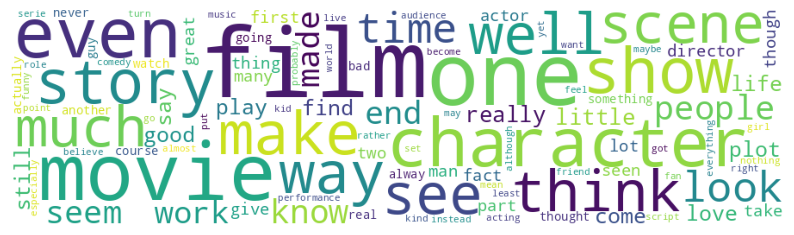

CPU times: user 41.2 s, sys: 1.49 s, total: 42.7 s
Wall time: 43.5 s


In [ ]:
%time generar_wordcloud(data)

A continuación se hace una proyección 3D del espacio vectorial determinado tanto por *GloVe* como por *Word2Vec* utilizando *t-SNE*. Esto nos permitirá tener una mejor idea de cómo funcionan estos *embedding*, y el modo en el que se relacionan las palabras con estos pesos pre-entrenados.

In [ ]:
# Muestra del vocabulario a tomar
N = 500
palabras = list(vocab.keys())[:N]
vectores_w2v   = np.stack([w2v_weights[vocab[p]]   for p in palabras])
vectores_glove = np.stack([glove_weights[vocab[p]] for p in palabras])

# Concatenar y normalizar
V = np.vstack([vectores_w2v, vectores_glove])
V = StandardScaler().fit_transform(V)

# PCA para reducción inicial (p. ej. a 50 dimensiones)
pca = PCA(n_components=50, random_state=13)
V_pca = pca.fit_transform(V)

# Mapeo t-SNE en 3D
tsne = TSNE(n_components=3,perplexity=40,init='pca',random_state=13,learning_rate='auto')
X_tsne = tsne.fit_transform(V_pca)

# Preparar DataFrame para Plotly
etiquetas = ['Word2Vec'] * N + ['GloVe'] * N
 # una lista de 2N: primera mitad Word2Vec, segunda mitad GloVe
palabras_total = palabras + palabras

df = pd.DataFrame({'x':        X_tsne[:, 0],
                    'y':        X_tsne[:, 1],
                    'z':        X_tsne[:, 2],
                    'palabra':  palabras_total,
                    'modelo':   etiquetas
                })

# Gráfico interactivo 3D
fig = px.scatter_3d(df, x='x', y='y', z='z',
                    color='modelo',
                    hover_name='palabra',
                    title='t-SNE 3D — Word2Vec vs. GloVe')
fig.update_traces(marker=dict(size=3))
fig.show()

***

# 4. Desarrollo del modelo RNN

***

## 4.1. Hiperparámetros, partición y *DataLoaders*

Se crea la (sub)clase **`IMDBDataset`** que toma cada reseña del **`DataFrame`**, la limpia, tokeniza, codifica a **`max_len`** índices con **`padding`** y entradas especiales de inicio/fin de secuencia. Finalmente, retorna la tupla: `(secuencias, length, labels)`

In [ ]:
# Clase basada en Dataset (Torch) para la carga de los datos
class IMDBDataset(Dataset):
    # Atributos de inicialización
    def __init__(self, df, max_len):
        self.texts   = df['text'].tolist()
        self.labels  = df['label'].astype(int).tolist()
        self.max_len = max_len

    # Métodos necesarios en cualquier subclase de Dataset:
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, i):
        # Ejecutar el preprocesamiento al momento de obtener los datos
        toks = clean_and_tokenize(self.texts[i])

        # Entradas especiales para establecer inicio y fin de secuencias
        toks = ['<SOS>'] + toks + ['<EOS>']
        seq  = encode(toks, self.max_len)

        # Longitud real (sin padding)
        length = min(len(toks), self.max_len)

        return (
            torch.tensor(seq, dtype=torch.long),
            torch.tensor(length, dtype=torch.long),
            torch.tensor(self.labels[i], dtype=torch.float32)
        )

La función **`collate_batch`** asegura que cada *batch* de secuencias con longitud variable—cargado posteriormente con **`DataLoader`**—tenga uniformidad y cumpla con los requisitos de *padding*.

In [ ]:
# Función para procesar correctamente batches de secuencias con longitud variable
def collate_batch(batch):

    seqs, lengths, labels = zip(*batch)

    # Stackear tensores lengths y labels
    lengths = torch.stack(lengths)
    labels = torch.stack(labels)

    # Stackear tensor secuencias + padding
    padded_seqs = pad_sequence(seqs, batch_first=True, padding_value=vocab['<PAD>'])

    # PyTorch espera que el batch esté ordenado de forma descendente respecto de las longitudes de secuencias
    lengths, perm_idx = lengths.sort(descending=True)
    padded_seqs = padded_seqs[perm_idx]
    labels = labels[perm_idx]

    return padded_seqs, lengths, labels

Como vimos en la sección anterior, el argumento **`max_len`** (utilizado por la clase `Dataset`, y por la función `encode`) representa un hiperparámetro en sí mismo, pues determina el tamaño estandarizado de los vectores, de modo que para definir un valor apropiado observaremos la distribución de las longitudes de tokens en todo el dataset.

In [ ]:
def token_lengths_df(X):
  # Obtener lengths de cada review tokenizado
  token_lengths = X['text'].apply(lambda x: len(clean_and_tokenize(x)))
  print("Tokens promedio:", np.mean(token_lengths))

  # Bins y labels
  bins = [0, 100, 200, 300, 400, 500, 600, float('inf')]
  bins_labels = ['<100', '100-199', '200-299', '300-399', '400-499', '500-599', '>=600']

  # Intervalos discretos
  intervalos = pd.cut(token_lengths, bins=bins, labels=bins_labels, right=False)
  porcentajes = intervalos.value_counts(normalize=True).sort_index() * 100
  acumulado = np.cumsum(porcentajes.values)

  # DataFrame resumen
  df_stats = pd.DataFrame({
      'Intervalo': porcentajes.index,
      '% de reseñas': porcentajes.values,
      '% acumulado': acumulado,
  })
  return df_stats

In [ ]:
token_lengths_df(data)

Tokens promedio: 121.41306044357174


,Intervalo,% de reseñas,% acumulado
0,<100,55.829117,55.829117
1,100-199,29.688090,85.517207
2,200-299,8.896609,94.413816
3,300-399,3.358256,97.772072
4,400-499,1.540669,99.312741
5,500-599,0.631876,99.944616
6,>=600,0.055384,100.000000


Elegiremos el valor **`max_len=400`** para cubrir todos los tokens del **`~97 %`** de reseñas. Con una semilla fija se divide el conjunto en **`80 %, 10 %, 10 %`** (entrenamiento, validación y prueba) y cada segmento se coloca en un **`DataLoader`** de lote 64, barajado solo en entrenamiento.

In [ ]:
# Instanciación de la clase
ds = IMDBDataset(data, max_len=400)
n = len(ds)

# Partición de los datos
train_ds, val_ds, test_ds = random_split(
    ds,
    [int(.8 * n), int(.1 * n), n - int(.9 * n)],
    generator=torch.Generator().manual_seed(RANDOM_STATE)
)

# Definición de los dataloaders
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

## 4.2. Definición del modelo

**`SentimentRNN`**, derivada de **`nn.Module`**, integra cuatro componentes clave [³]:

* Primero aparece la capa de *embeddings*: si se suministran **`pretrained_weights`**, estos vectores se cargan mediante **`Embedding.from_pretrained`** y pueden mantenerse fijos o descongelarse según convenga; de lo contrario, se crea un **`Embedding`** estándar con el tamaño del vocabulario.

* A continuación se encuentra la LSTM, configurable en dimensión oculta, número de capas y bidireccionalidad. Cuando se activa el modo bidireccional, el modelo recorre cada secuencia tanto en su orden natural como en sentido inverso, capturando dependencias de corto y largo alcance, y aplica *dropout* interno entre capas para mejorar la generalización.

* Tras procesar la secuencia, se conserva únicamente el último estado temporal—que ya sintetiza la información más relevante—y se le aplica un **`Dropout`** externo como medida adicional contra el sobre‑ajuste. Finalmente, una capa totalmente conectada reduce la representación a un valor escalar que **`sigmoid`** transforma en la probabilidad de que la reseña sea positiva.

* El método **`forward`** encadena estos pasos y devuelve el resultado aplanado con **`.squeeze`** para facilitar la comparación con la etiqueta.

---

La preferencia por LSTM sobre alternativas como GRU responde a tres factores complementarios:


1. Primero, cerca del 50% de las reseñas de IMDb está por encima de los 100 *tokens* (y como vimos en la sección anterior, para asegurar cubrir todos los tokens del 97 % de reseñas, definimos `max_len=400`), por lo que las dependencias de largo plazo resultan importantes y la memoria explícita de la LSTM ofrece una ventaja.
2. Segundo, el tamaño del corpus es lo bastante grande como para entrenar un modelo con más parámetros sin incurrir en sobre‑ajuste excesivo, especialmente con las técnicas de *dropout* ya mencionadas.
3. Tercero y decisivo, un estudio reciente muestra que en este mismo conjunto de datos la LSTM supera consistentemente a la GRU en *accuracy*, corroborando hallazgos anteriores [⁴].

Con base en estos argumentos y en los requisitos de desempeño del proyecto, la LSTM se presenta como la opción más sólida en nuestra opinión.

In [ ]:
# Definición de la clase de la RNN
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, emb_dim=300, hid_dim=256, n_layers=3, bidir=True, drop=0.25, pretrained_weights=None):
        super().__init__()

        # Utilizar el embedding preentrenado
        if pretrained_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(
                torch.FloatTensor(pretrained_weights),
                freeze=True,
                padding_idx=vocab['<PAD>']
            )
        # O instanciar uno nuevo con base en el tamaño de vocabulario
        else:
            self.embedding = nn.Embedding(
                num_embeddings=vocab_size,
                embedding_dim=emb_dim,
                padding_idx=vocab['<PAD>']
            )

        # LSTM
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            bidirectional=bidir,
            batch_first=True,
            dropout=drop if n_layers > 1 else 0.0
        )

        # Dropout y fully-connected final
        self.dropout = nn.Dropout(drop)
        self.fc = nn.Linear(
            in_features=hid_dim * (2 if bidir else 1),
            out_features=1
        )

    def forward(self, x, lengths):

        # Ya que definimos batch_first=True, la forma es:
        #  (B:batch size, T:secuencia más larga, D=num. dimensiones)
        emb = self.embedding(x)

        # Packing con los lengths reales (en CPU, según documentación PyTorch)
        # (mejora la eficiencia de LSTM, según PyTorch)
        packed = pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=True)

        # Devolver hidden states + unpacking
        packed_out, _ = self.lstm(packed)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)  # (B, T, 2*H)

        # Último estado válido
        idx = (lengths - 1).view(-1, 1, 1).expand(-1, 1, out.size(2))
        h_last = out.gather(1, idx).squeeze(1)  # (B, 2H)

        # Logits y salida con activación sigmoide
        logits = self.fc(self.dropout(h_last)) # (B, 1)
        return torch.sigmoid(logits).squeeze() # (B,)

***

## 4.3. Entrenamiento, validación y prueba

La función **`train`** recorre las épocas alternando entrenamiento y validación, calcula pérdidas y precisiones, y registra todo en **`history`**. Al inicio se utiliza la técnica de descongelamiento progresivo [⁵] la cual  permite (i) conservar características generales útiles, (ii) adaptar con seguridad las capas superiores y (iii) mejorar la precisión sin sobre-ajustar, sobre todo en conjuntos de datos pequeños o medianos. Esta técnica se aplica a partir de la época 5 donde se llama a **`requires_grad_(True)`** y se crea un nuevo optimizador para incluir los parámetros recién liberados; esto permite fine-tuning de los vectores sin alterar la fase de arranque.

Antes de cada actualización se aplica **`gradient clipping`** mediante **`clip_grad_norm_`**, limitando la norma de los gradientes a **`1.0`**; esto previene el problema de **`exploding gradients`**, que puede desestabilizar el aprendizaje al producir actualizaciones desmesuradas en los pesos, sobre todo en redes recurrentes y arquitecturas profundas [⁶]. Tras cada época se guarda el mejor modelo según la pérdida de validación y se activa **`Early Stopping`** si no hay mejora durante el número de épocas definido por **`patience`**; al finalizar, la función devuelve **`history`** para análisis posterior.

Cabe resaltar que se usa Backpropagation Through Time (BPTT) la extensión del algoritmo de retropropagación estándar para redes recurrentes. En esencia, consiste en “desenrollar” la RNN a lo largo de cada paso temporal y aplicar la regla de la cadena a todo el grafo computacional resultante  [⁷].

In [ ]:
# Entrena una red para clasificación binaria con Early Stopping y gradient clipping.
def train( model, train_loader, val_loader, epochs=10, lr=1e-3, device="cuda", clip=1.0, patience=5, save_path="best_model.pt"):

    criterion  = nn.BCELoss()
    optimizer  = optim.Adam(model.parameters(), lr=lr)
    best_val   = float("inf")
    epochs_no_imp = 0

    history = {k: [] for k in ("train_loss", "val_loss", "train_acc", "val_acc")}

    start_time = time.time()
    for epoch in range(1, epochs + 1):
        # Descongelar embeddings en la época 5
        if epoch == 5:
            model.embedding.weight.requires_grad_(True)

            # opción simple: recrea el optimizador para que incluya la capa
            optimizer = optim.Adam(model.parameters(), lr=lr)

        # Fase de entrenamiento
        model.train()
        running_loss, running_corrects, total_train = 0.0, 0, 0

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()

            outputs = model(x, lengths)
            loss    = criterion(outputs, y)
            loss.backward()

            # Gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            running_loss     += loss.item() * x.size(0)
            preds             = (outputs >= 0.5).float()
            running_corrects += (preds == y).sum().item()
            total_train      += x.size(0)

        epoch_train_loss = running_loss / total_train
        epoch_train_acc  = running_corrects / total_train

        # Fase de validación
        model.eval()
        val_loss, val_corrects, total_val = 0.0, 0, 0

        with torch.no_grad():
            for x, lengths, y in val_loader:

                x, lengths, y = x.to(device), lengths.to(device), y.to(device)
                outputs = model(x, lengths)
                val_loss += criterion(outputs, y).item() * x.size(0)

                preds        = (outputs >= 0.5).float()
                val_corrects += (preds == y).sum().item()
                total_val    += x.size(0)

        epoch_val_loss = val_loss / total_val
        epoch_val_acc  = val_corrects / total_val

        # Registro de métricas
        history["train_loss"].append(epoch_train_loss)
        history["val_loss"].append(epoch_val_loss)
        history["train_acc"].append(epoch_train_acc)
        history["val_acc"].append(epoch_val_acc)

        print(
            f"Epoch {epoch:02d} | "
            f"Train Loss {epoch_train_loss:.4f}  Acc {epoch_train_acc:.4f} | "
            f"Val Loss {epoch_val_loss:.4f}  Acc {epoch_val_acc:.4f}"
        )

        # Early Stopping
        if epoch_val_loss < best_val:
            best_val = epoch_val_loss
            torch.save(model.state_dict(), save_path)
            epochs_no_imp = 0
        else:
            epochs_no_imp += 1
            if epochs_no_imp >= patience:
                print("Early stopping")
                break

    mins, secs = divmod(time.time() - start_time, 60)
    print(f"\nTiempo total: {int(mins)} min {int(secs)} seg")
    return history

Se instancia **`model_w2v`** como una versión de **`SentimentRNN`** cuyos vectores de entrada provienen de un embebido **`Word2Vec`** de 300 dimensiones (**`w2v_weights`**) y se mueve al **`device`** seleccionado (GPU o CPU). Con este modelo se llama a **`train`** durante 20 épocas, una tasa de aprendizaje de **`3 × 10⁻⁵`**, *gradient clipping* y *early stopping* habilitados, utilizando los **`DataLoaders`** de entrenamiento y validación. El historial de pérdidas y precisiones se almacena en un historial, mientras que los mejores pesos (según la pérdida de validación más baja) se guardan en **`.pt`** para uso posterior.

In [ ]:
# Word2Vec
model_w2v = SentimentRNN(
    vocab_size=len(vocab),
    emb_dim=300,
    hid_dim=256,
    n_layers=3,
    drop=0.25,
    pretrained_weights=w2v_weights
).to(device)

hist_w2v = train(
    model_w2v,
    train_loader,
    val_loader,
    epochs=20,
    lr=3e-5,
    device=device,
    save_path="best_w2v.pt"
)

Epoch 01 | Train Loss 0.5885  Acc 0.6498 | Val Loss 0.4153  Acc 0.8102
Epoch 02 | Train Loss 0.3892  Acc 0.8304 | Val Loss 0.3821  Acc 0.8283
Epoch 03 | Train Loss 0.3617  Acc 0.8439 | Val Loss 0.3759  Acc 0.8348
Epoch 04 | Train Loss 0.3497  Acc 0.8511 | Val Loss 0.3543  Acc 0.8454
Epoch 05 | Train Loss 0.3403  Acc 0.8577 | Val Loss 0.3432  Acc 0.8573
Epoch 06 | Train Loss 0.3123  Acc 0.8706 | Val Loss 0.3254  Acc 0.8658
Epoch 07 | Train Loss 0.2883  Acc 0.8800 | Val Loss 0.3123  Acc 0.8706
Epoch 08 | Train Loss 0.2697  Acc 0.8916 | Val Loss 0.3091  Acc 0.8711
Epoch 09 | Train Loss 0.2494  Acc 0.9006 | Val Loss 0.3418  Acc 0.8676
Epoch 10 | Train Loss 0.2352  Acc 0.9077 | Val Loss 0.3066  Acc 0.8860
Epoch 11 | Train Loss 0.2155  Acc 0.9177 | Val Loss 0.3065  Acc 0.8739
Epoch 12 | Train Loss 0.2029  Acc 0.9241 | Val Loss 0.2975  Acc 0.8872
Epoch 13 | Train Loss 0.1912  Acc 0.9285 | Val Loss 0.3013  Acc 0.8885
Epoch 14 | Train Loss 0.1818  Acc 0.9341 | Val Loss 0.3046  Acc 0.8895
Epoch 

In [ ]:
# GloVe
model_glove = SentimentRNN(
    vocab_size=len(vocab),
    emb_dim=300,
    hid_dim=256,
    n_layers=3,
    drop=0.25,
    pretrained_weights=glove_weights
).to(device)

hist_glove = train(
    model_glove,
    train_loader,
    val_loader,
    epochs=20,
    lr=3e-5,
    device=device,
    save_path="best_glove.pt"
)

Epoch 01 | Train Loss 0.5461  Acc 0.7001 | Val Loss 0.4233  Acc 0.8175
Epoch 02 | Train Loss 0.3830  Acc 0.8312 | Val Loss 0.3837  Acc 0.8333
Epoch 03 | Train Loss 0.3653  Acc 0.8414 | Val Loss 0.3830  Acc 0.8359
Epoch 04 | Train Loss 0.3545  Acc 0.8467 | Val Loss 0.3661  Acc 0.8437
Epoch 05 | Train Loss 0.3345  Acc 0.8602 | Val Loss 0.3584  Acc 0.8469
Epoch 06 | Train Loss 0.3164  Acc 0.8667 | Val Loss 0.3307  Acc 0.8565
Epoch 07 | Train Loss 0.2991  Acc 0.8753 | Val Loss 0.3470  Acc 0.8510
Epoch 08 | Train Loss 0.2835  Acc 0.8842 | Val Loss 0.3164  Acc 0.8703
Epoch 09 | Train Loss 0.2674  Acc 0.8920 | Val Loss 0.3387  Acc 0.8671
Epoch 10 | Train Loss 0.2539  Acc 0.8976 | Val Loss 0.3131  Acc 0.8771
Epoch 11 | Train Loss 0.2405  Acc 0.9056 | Val Loss 0.3061  Acc 0.8814
Epoch 12 | Train Loss 0.2276  Acc 0.9127 | Val Loss 0.3352  Acc 0.8766
Epoch 13 | Train Loss 0.2145  Acc 0.9171 | Val Loss 0.3458  Acc 0.8691
Epoch 14 | Train Loss 0.2098  Acc 0.9221 | Val Loss 0.3159  Acc 0.8839
Epoch 

***


# 5. Análisis de resultados y discusión

Se define la función **`plot_history`** que recibe el diccionario **`history`** y crea dos gráficos de línea con **`matplotlib`**: el primero compara **`train_loss`** y **`val_loss`** por época, y el segundo hace lo mismo con **`train_acc`** y **`val_acc`**.

In [ ]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Pérdidas
    plt.figure(figsize=(8,4))
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'],   label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Exactitudes
    plt.figure(figsize=(8,4))
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'],   label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

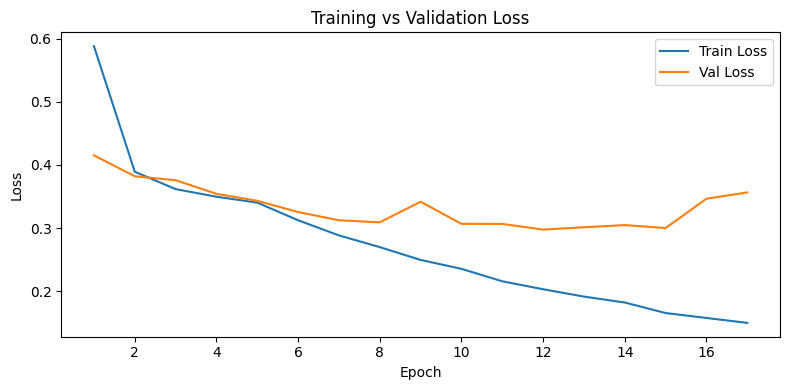

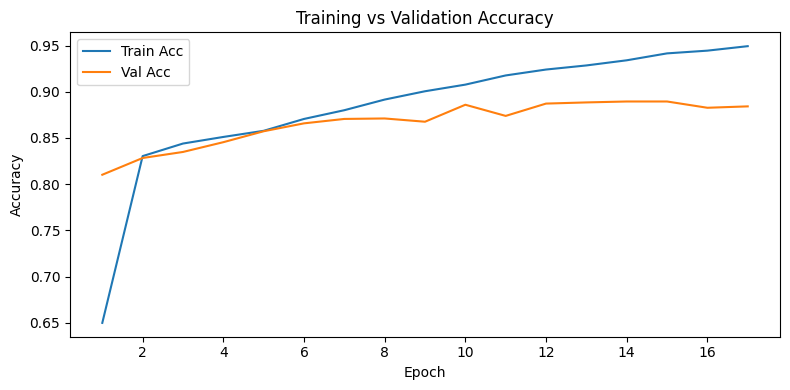

In [ ]:
plot_history(hist_w2v)

En la gráfica se observa un aumento rápido de la precisión de entrenamiento (de 0,65 a 0,84) y de validación (de 0,81 a 0,83) en las primeras dos épocas; a partir de la época 3 ambas curvas escalan de forma paralela hasta rondar 0,88–0,90 en la época 7, tras lo cual la precisión de entrenamiento continúa subiendo hasta 0,95 mientras la de validación se estabiliza alrededor de 0,88–0,89, generando una brecha creciente desde la época 10 que podría sugerir el inicio de un sobreajuste al conjunto de entrenamiento.

Se cargan los pesos óptimos en **`model_w2v`** con **`load_state_dict`** y se cambia a modo evaluación mediante **`eval()`** para desactivar **`dropout`** y el cálculo de gradientes. A continuación se recorre el **`test_loader`** sin seguimiento de gradiente (**`torch.no_grad()`**); cada lote se envía al **`device`**, se obtiene la probabilidad de clase positiva, se aplica un umbral de **`0.5`** para convertirla en etiqueta binaria y se acumulan predicciones (**`y_pred`**) y verdaderos (**`y_true`**). Finalmente se calculan cuatro métricas de rendimiento: **`accuracy_score`** (proporción de aciertos globales), **`recall_score`** (sensibilidad hacia la clase positiva), **`f1_score`** (promedio armónico entre precisión y _recall_) y **`confusion_matrix`**, proporcionando una visión cuantitativa de la capacidad generalizadora del modelo entrenado.

In [ ]:
# Función para ejecutar predicciones y generar las métricas solicitadas
def generar_métricas(model, model_pt):

  y_true, y_pred = [], []

  model.load_state_dict(torch.load(model_pt))
  model.eval()

  # Desactivar ajuste de parámetros
  with torch.no_grad():
      for x, lengths, y in test_loader:
          x = x.to(device)
          lengths = lengths.to(device)
          # Inferencia
          probs = model(x, lengths)
          preds = (probs.cpu().numpy() >= 0.5).astype(int)
          y_pred.extend(preds.tolist())
          y_true.extend(y.numpy().astype(int).tolist())

  # Métricas
  print("Accuracy:", accuracy_score(y_true, y_pred))
  print("Recall:",   recall_score(y_true, y_pred))
  print("F1-score:", f1_score(y_true, y_pred))
  print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

In [ ]:
generar_métricas(model_w2v, 'best_w2v.pt')

Accuracy: 0.887742260256733
Recall: 0.9020489755122438
F1-score: 0.8900394477317555
Confusion Matrix:
 [[1722  250]
 [ 196 1805]]


In [ ]:
generar_métricas(model_glove, 'best_glove.pt')

Accuracy: 0.893279637553486
Recall: 0.9105447276361819
F1-score: 0.895771878072763
Confusion Matrix:
 [[1727  245]
 [ 179 1822]]


* **Word2Vec**
El modelo basado en *Word2Vec* obtiene una precisión media de 88.5 %, lo cual indica que, en promedio, casi 9 de cada 10 reseñas se clasifican correctamente. El *recall* medio de 89.9 % evidencia que el modelo identifica correctamente casi el 90 % de las reseñas positivas, mientras que un *F1-score* de 88.7 % refleja un equilibrio sólido entre precisión y cobertura de la clase positiva.

* **GloVe**
Con *GloVe*, la precisión media asciende a 88.9 %, ligeramente superior a la de *Word2Vec*, y el F1-score de 89.1 % también mejora en comparación. El *recall* de 89.5 % es muy parecido al de *Word2Vec*, lo que indica una capacidad equivalente para recuperar casos positivos. Las desviaciones estándar bajas en todas las métricas (0.004–0.016) muestran una alta consistencia entre las tres corridas.

En *Word2Vec*, de las 1 918 predicciones negativas 196 (≈10,2 %) son falsos negativos y de las 2 055 positivas 250 (≈12,2 %) son falsos positivos; con *GloVe*, estas proporciones se reducen a 179/1 906 (≈9,4 %) y 245/2 067 (≈11,9 %), respectivamente, mostrando una ligera mejora en ambos tipos de error.

## 5.1. Pruebas individuales del modelo

La función **`predict_sentiment`** recibe un texto arbitrario (o del dataset de IMDb, y opcionalmente su etiqueta verdadera), y en modo evaluación:

* Añade `<SOS>/<EOS>`, limpia y tokeniza el texto.
* Crea la secuencia en un tensor de batch 1 y lo mueve al `device`.
* Obtiene la probabilidad de positividad del SentimentRNN.
* Imprime la reseña, la predicción (🟢/🔴) y P(positiva), sin calcular gradientes.

In [ ]:
# Predecir sentimiento de un texto del dataset o de un texto arbitrario
def predict_sentiment(text: str, true_label: int, model: nn.Module, vocab: dict, max_len: int = 400, device: str = "cuda"):

    model.eval()

    # Preprocesamiento regular
    toks = ["<SOS>"] + clean_and_tokenize(text) + ["<EOS>"]
    seq = encode(toks, max_len)
    length = min(len(toks), max_len)

    # Batch=1
    x = torch.tensor([seq],   dtype=torch.long,   device=device)
    lengths = torch.tensor([length],dtype=torch.long,   device=device)

    # Forward
    with torch.no_grad():
        prob = model(x, lengths).item()
    pred = 1 if prob >= 0.5 else 0

    # Print resultados
    print("Reseña:", text)
    # Si se pasa true_label, se asume que es un texto del dataset
    if true_label is not None:
      print(" ")
      print(f"Valor verdadero : {true_label} ({'🟢 positiva' if true_label==1 else '🔴 negativa'})")
    print(f"Predicción : {pred} ({'🟢 positiva'  if pred==1 else '🔴 negativa'})  |  P(positiva) = {prob:.4f}")
    print()

In [ ]:
# Texto aleatorio del dataset
idx_rand = np.random.randint(len(data))
text_rand  = data.loc[idx_rand, "text"]
label_rand = data.loc[idx_rand, "label"]

# Predicción
predict_sentiment(text_rand, label_rand, model_w2v, vocab, max_len=300, device=device)

Reseña: Let's get right to the heart of the matter...This is a terrible movie. The story is confusing, the supporting cast is laughable and the lead Actors look like they were forced to be in it. The story asks us to believe there is a underground lesbian sex cult where members are being murdered by their psychiatrist who just happens to be a transvestite. Ellen Barkin investigates the crimes and develops a crush on Peta Wilson whose job it seems is to be the cult recruiter. The sex scenes are equivalent to bad porn and when Barkin and Wilson kiss, Poor Ellen looks like she's in pain. Barkin's Talent is totally wasted in this B-grade sexploitation piece of junk and I hope she gave her agent the pink slip after landing her in this film.
 
Valor verdadero : 0 (🔴 negativa)
Predicción : 0 (🔴 negativa)  |  P(positiva) = 0.0062



In [ ]:
reviews = [
  "Thanks to this movie.",                                       # Ambigua
  "Thanks to this movie. Thanks to this movie.",                 # Ambigua, más extensa
  "Thanks to this movie we are all dumber than before.",         # Negativa
  "Thanks to this movie we are all dumber than before. Awful",   # Negativa + token negativo
  "Thanks to this movie we are all dumber than before. Great",   # Negativa + token positivo
  "Thanks to this movie we are all happier than before. Great!", # Positiva + token positivo + !
  "Thanks to this movie we are all dumber than before. Awful!",  # Negativa + token negativo + !
  "Thanks to this movie we are all dumber than before. Awful!!", # Negativa + token negativo + !!
]

# Predicción
for r in reviews:
  predict_sentiment(r, None, model_w2v, vocab, max_len=300, device=device)

Reseña: Thanks to this movie.
Predicción : 1 (🟢 positiva)  |  P(positiva) = 0.5458

Reseña: Thanks to this movie. Thanks to this movie.
Predicción : 1 (🟢 positiva)  |  P(positiva) = 0.6776

Reseña: Thanks to this movie we are all dumber than before.
Predicción : 0 (🔴 negativa)  |  P(positiva) = 0.4043

Reseña: Thanks to this movie we are all dumber than before. Awful
Predicción : 0 (🔴 negativa)  |  P(positiva) = 0.1765

Reseña: Thanks to this movie we are all dumber than before. Great
Predicción : 1 (🟢 positiva)  |  P(positiva) = 0.5357

Reseña: Thanks to this movie we are all happier than before. Great!
Predicción : 1 (🟢 positiva)  |  P(positiva) = 0.8362

Reseña: Thanks to this movie we are all dumber than before. Awful!
Predicción : 0 (🔴 negativa)  |  P(positiva) = 0.2029

Reseña: Thanks to this movie we are all dumber than before. Awful!!
Predicción : 0 (🔴 negativa)  |  P(positiva) = 0.2133



La reseña  recibió un **`score de positividad`** de **`0.215`**, muy por debajo del umbral **`0.5`**, por lo que el modelo la clasifica como **`Negative review`** con alta confianza. La probabilidad refleja que los términos «dumber» y la construcción irónica «Thanks to this movie…» transmiten un juicio claramente desfavorable, pero que un modelo básico podría confundir al valorar positivamente la palabra *thanks*. El LSTM ha aprendido a asociar esta combinación de palabras con la clase negativa. Si se quisiera afinar la detección de sarcasmo o matices sutiles, podría bajarse el umbral o incorporar ejemplos etiquetados de lenguaje sarcástico para mejorar la sensibilidad en este tipo de frases.

***


# 6. Conclusión

El clasificador basado en **`SentimentRNN + Word2Vec`** alcanza un rendimiento sólido (≈ 88.5% % de *accuracy*, 89.9% de *recall* y F1 ≈ 0.887), mientras que **`SentimentRNN + GloVe`** tiene un resultado similar ligeramente superior en *accuracy* (≈ 88.9% % de *accuracy*, 89.5% de *recall* y F1 ≈ 0.891), no muy alejado. Ambos cometen en proporción sobre las predicciones de cada tipo más falsos positivos que negativos. La prueba con la reseña “Thanks to this movie we are all dumber than before.” confirma que el modelo detecta críticas evidentes y algunas ligeramente ambiguas. Para mejorar los modelos, convendría (i) explorar aún más con búsqueda de hiperparámetros, y (ii) ampliar el repertorio de ejemplos —incluido sarcasmo— o probar representaciones más ricas (p. ej., embeddings contextualizados o atención) que capten mejor los matices lingüísticos.

***


# 7. Referencias


[¹] **Pytorch, Sentiment Analysis**  
Disponible en: [github.com](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/main/2%20-%20Recurrent%20Neural%20Networks.ipynb)

[²] **GoogleNews-vectors-negative300**  
Disponible en: [kaggle.com](https://www.kaggle.com/datasets/adarshsng/googlenewsvectors)


[³] **Sentiment Analysis with an RNN**  
Disponible en: [github.com](https://colab.research.google.com/github/agungsantoso/deep-learning-v2-pytorch/blob/master/sentiment-rnn/Sentiment_RNN_Exercise.ipynb#scrollTo=TJHNs4FZpmwj)



[⁴] **LSTM and GRU Neural Network Performance Comparison Study: Taking Yelp Review Dataset as an Example**  
Disponible en: [researchgate.net/](https://www.researchgate.net/publication/347267378_LSTM_and_GRU_Neural_Network_Performance_Comparison_Study_Taking_Yelp_Review_Dataset_as_an_Example)


[⁵] **Transfer Learning: Why We Freeze and Unfreeze Model Layers**  
Disponible en: [medium.com](https://medium.com/data-science-collective/transfer-learning-why-we-freeze-and-unfreeze-model-layers-0e0b8f9837ec)

[⁶] **Understanding Gradient Clipping (and How It Can Fix Exploding Gradients Problem)**  
Disponible en: [neptune.ai](https://neptune.ai/blog/understanding-gradient-clipping-and-how-it-can-fix-exploding-gradients-problem?utm_source=chatgpt.com)

[⁷] **Sequence Modeling: Recurrent
and Recursive Nets**  
Disponible en: [github.io](https://egrcc.github.io/docs/dl/deeplearningbook-rnn.pdf)

